In [3]:
from torchrl.data import TensorDictPrioritizedReplayBuffer, TensorDictReplayBuffer
from torchrl.data.replay_buffers.storages import LazyMemmapStorage
from tensordict import TensorDict

In [ ]:
# load replay buffer
batch_size = 128
prefetch = 1

bt_init_scratch_dir = "../data/meta_buffer_init_2"
stored_td = TensorDict.load_memmap(bt_init_scratch_dir)

replay_buffer = TensorDictReplayBuffer(
    pin_memory=False,
    prefetch=prefetch,
    storage=LazyMemmapStorage(
                50_000,
                scratch_dir=bt_init_scratch_dir,
                device="cpu",
            ),
    batch_size=batch_size,
)
replay_buffer.extend(stored_td)

In [26]:
td = replay_buffer.sample()

In [36]:
import sys
sys.path.append("../src")
from configs import BaseConfig
from pkg_torchrl.meta.sac import MetaSAC

config = BaseConfig()
meta_algo = MetaSAC(config.meta)

In [37]:
from tqdm import tqdm

num_updates = 100

losses = TensorDict({}, batch_size=[num_updates])
for i in tqdm(range(num_updates)):
    sampled_tensordict = replay_buffer.sample()

    if sampled_tensordict.device != meta_algo.device:
        sampled_tensordict = sampled_tensordict.to(meta_algo.device)

    loss_td = meta_algo.loss_module(sampled_tensordict)

    loss = meta_algo._loss_backward(loss_td)
    losses[i] = loss

    meta_algo.target_net_updater.step()

    # if meta_algo.config.meta_prioritize:
    #     loss_key = "loss_critic" if "loss_critic" in loss else "loss_qvalue"
    #     sampled_tensordict.set(
    #         loss_key, loss[loss_key] * torch.ones(sampled_tensordict.shape, device=meta_algo.device))
    #     meta_algo.replay_buffer.update_tensordict_priority(sampled_tensordict)


100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


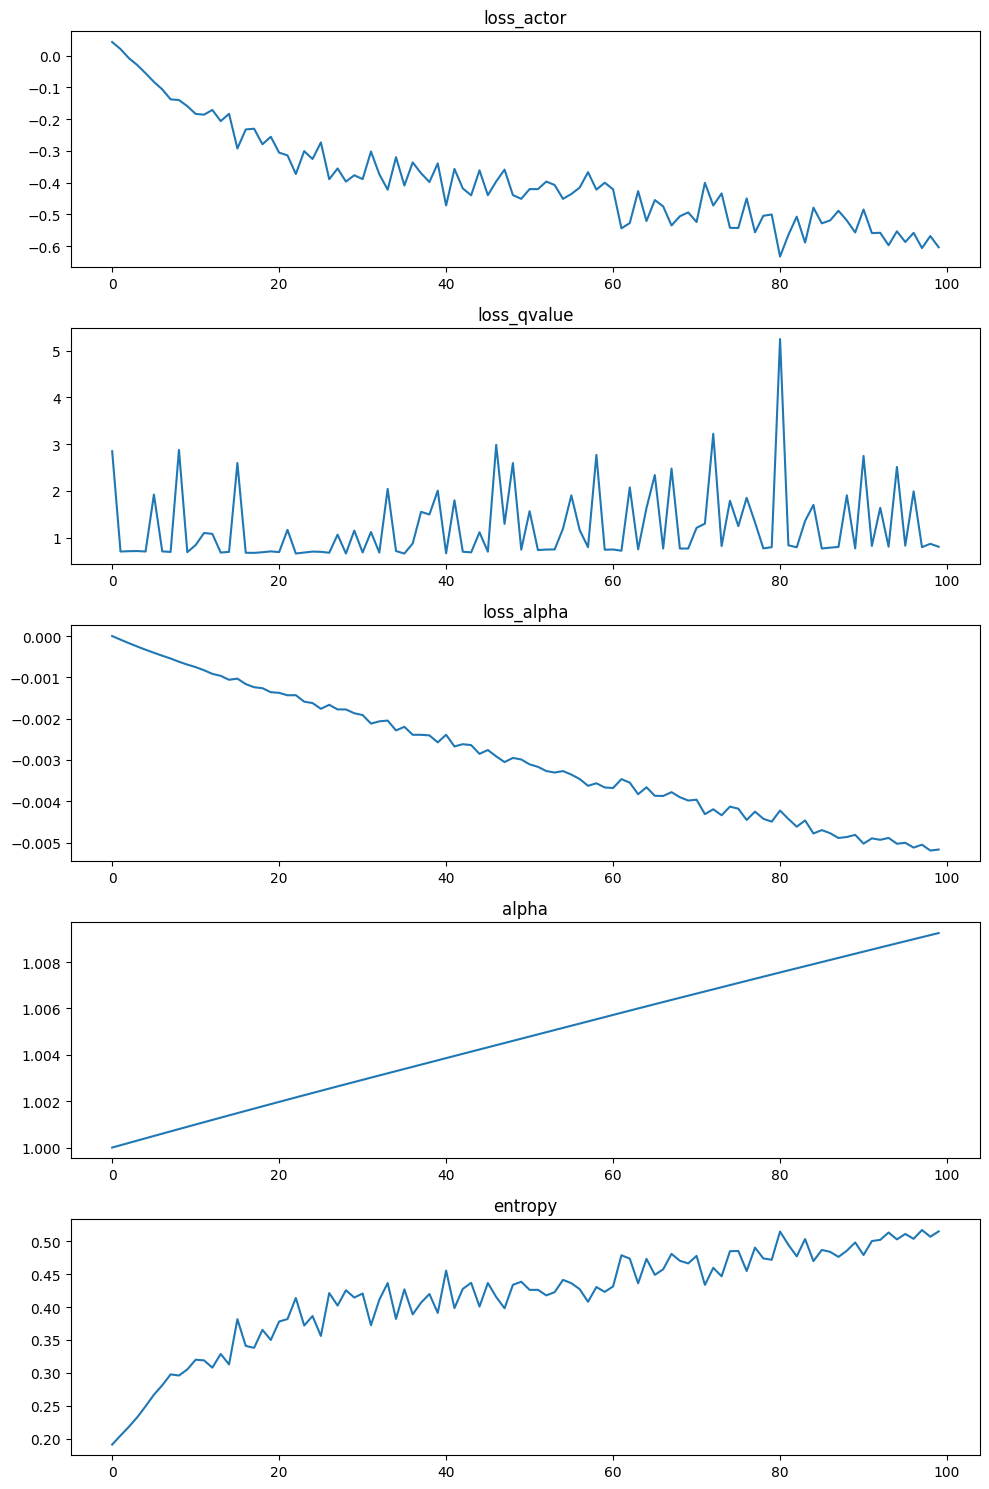

In [39]:
losses
import matplotlib.pyplot as plt

keys_to_plot = ['loss_actor', 'loss_qvalue', 'loss_alpha', 'alpha', 'entropy']
fig, axs = plt.subplots(len(keys_to_plot), 1, figsize=(10, 15))

for i, key in enumerate(keys_to_plot):
    axs[i].plot(losses[key].cpu().numpy())
    axs[i].set_title(key)

plt.tight_layout()
plt.show()